# Bayesian imputation for missing values in discrete covariates with HMC

Missing data is a very widespread problem in practical applications, both in covariates ('explanatory variables') and outcomes.
When performing bayesian inference with MCMC, imputing discrete missing values is not possible using Hamiltonian Monte Carlo techniques.
One way around this problem is to create a new model that enumerates the discrete variables and does inference over the new model, which, for a single discrete variable, is a mixture model. (see e.g. [Stan's user guide on Latent Discrete Parameters](https://mc-stan.org/docs/2_18/stan-users-guide/change-point-section.html))
Enumerating the discrete latent sites requires some manual math work that can get tedious for complex models.
Inference by automatic is implemented in numpyro and allows for a very conveniant way of dealing with missing discrete data.


In [1]:
import numpyro
from jax import numpy as jnp, random, ops
from jax.scipy.special import expit
from numpyro import distributions as dist, sample
from numpyro.infer.mcmc import MCMC
from numpyro.infer.hmc import NUTS
from math import inf
from graphviz import Digraph

simkeys = random.split(random.PRNGKey(0), 10)
nsim    = 5000
mcmc_key = random.PRNGKey(1)

First we will simulate data with correlated binary covariates. The assumption is that we wish to estimate parameter for some parametric model without bias (e.g. for inferring a causal effect). For several different missing data patterns we will see how to impute the values to lead to unbiased models. 

The basic data structure is as follows. Z is a latent variable that gives rise to the marginal dependence between A and B, the observed covariates. We will consider different missing data mechanisms for variable A, where variable B and Y are fully observed. The effects of A and B on Y are the effects of interest

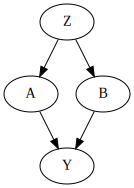

In [2]:
dot = Digraph()
dot.node('A')
dot.node('B')
dot.node('Z')
dot.node('Y')
dot.edges(['ZA', 'ZB', 'AY', 'BY'])
dot

In [3]:
b_A = 0.25
b_B = 0.25
s_Y = 0.25
Z = random.normal(simkeys[0], (nsim, ))
A = random.bernoulli(simkeys[1], expit(Z))
B = random.bernoulli(simkeys[2], expit(Z))
Y = A * b_A + B * b_B + s_Y * random.normal(simkeys[3], (nsim,))

## MAR condiditional on outcome
Generate missing values in A, conditional on the value of Y. 

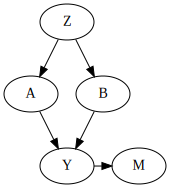

In [4]:
dot_mnar_y = Digraph()
with dot_mnar_y.subgraph() as s:
    s.attr(rank='same')
    s.node('Y')
    s.node('M')
dot_mnar_y.node('A')
dot_mnar_y.node('B')
dot_mnar_y.node('Z')
dot_mnar_y.node('M')
dot_mnar_y.edges(['YM', 'ZA', 'ZB', 'AY', 'BY'])
dot_mnar_y

In [5]:
A_isobs = random.bernoulli(simkeys[4], expit(3*(Y - Y.mean())))
Aobs = jnp.where(A_isobs, A, -1)
A_obsidx = jnp.where(A_isobs)

# generate complete case arrays
Acc = Aobs[A_obsidx]
Bcc = B[A_obsidx]
Ycc = Y[A_obsidx]

We will evaluate 2 approaches:
    - 1 complete case analysis (which is biased)
    - 2 with imputation (conditional on B)
    
Note that explicitly including Y in the imputation model for A is unneccesary.
The sampled imputations for A will condition on Y indirectly as the likelihood of Y is conditional on A.
So values of A that give high likelihood to Y will be sampled more often than other values.

In [6]:
def ccmodel(A, B, Y):
    ntotal = A.shape[0]
    # get parameters of outcome model
    b_A = sample('b_A', dist.Normal(0, 2.5))
    b_B = sample('b_B', dist.Normal(0, 2.5))
    s_Y = sample('s_Y', dist.HalfCauchy(2.5))
    
    with numpyro.plate('obs', ntotal):
        ### outcome model 
        eta_Y = b_A * A + b_B * B
        sample("obs_Y", dist.Normal(eta_Y, s_Y), obs=Y)

In [7]:
cckernel = NUTS(ccmodel)
ccmcmc   = MCMC(cckernel, num_warmup=250, num_samples=750)
ccmcmc.run(mcmc_key, Acc, Bcc, Ycc)
ccmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:03<00:00, 326.39it/s, 3 steps of size 3.73e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.30      0.01      0.30      0.28      0.31    429.25      1.00
       b_B      0.28      0.01      0.28      0.27      0.29    409.07      1.00
       s_Y      0.25      0.00      0.25      0.24      0.25    372.04      1.00

Number of divergences: 0


In [8]:
def impmodel(A, B, Y):
    ntotal = A.shape[0]
    A_isobs = A >= 0
    A_obsidx = jnp.where(A_isobs)[0]
    A_missidx = jnp.where(1 - A_isobs)[0]

    # get parameters of imputation model
    mu_A = sample("mu_A", dist.Normal(0, 2.5))
    b_B_A = sample("b_B_A", dist.Normal(0, 2.5))    

    # get parameters of outcome model
    b_A = sample('b_A', dist.Normal(0, 2.5))
    b_B = sample('b_B', dist.Normal(0, 2.5))
    s_Y = sample('s_Y', dist.HalfCauchy(2.5))
    
    with numpyro.plate('obs', ntotal):
        ### imputation model
        # get linear predictor for missing values
        eta_A = mu_A + B * b_B_A

        # sample imputation values for A
        # mask out to not add log_prob to total likelihood right now
        Aimp = sample("A", dist.Bernoulli(logits=eta_A).mask(False)) 
        
        # 'manually' calculate the log_prob
        log_prob = dist.Bernoulli(logits=eta_A).log_prob(Aimp)
        
        # cancel out enumerated values that are not equal to observed values
        log_prob = jnp.where(A_isobs & (Aimp != A), -inf, log_prob) 
        
        # add to total likelihood for sampler
        numpyro.factor('A_obs', log_prob)
            
        ### outcome model 
        eta_Y = b_A * Aimp + b_B * B
        sample("obs_Y", dist.Normal(eta_Y, s_Y), obs=Y)


In [9]:
impkernel = NUTS(impmodel)
impmcmc   = MCMC(impkernel, num_warmup=250, num_samples=750)
impmcmc.run(mcmc_key, Aobs, B, Y)
impmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:06<00:00, 163.45it/s, 7 steps of size 4.56e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.25      0.01      0.25      0.24      0.26    435.05      1.00
       b_B      0.25      0.01      0.25      0.24      0.26    469.67      1.00
     b_B_A      0.74      0.08      0.74      0.61      0.86    285.16      1.00
      mu_A     -0.39      0.06     -0.39     -0.48     -0.28    259.15      1.00
       s_Y      0.25      0.00      0.25      0.25      0.25    709.01      1.00

Number of divergences: 0


As we can see, when data are missing conditionally on Y, imputation leads to consistent estimation of the parameter of interes (b_A and b_B)

## MNAR condiditional on covariate

When data are missing conditional on unobserved data, things get more tricky.
Here we will generate missing values in A, conditional on the value of A itself (missing not at random (MNAR), but missing at random conditional on A)

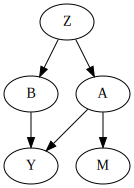

In [10]:
dot_mnar_x = Digraph()
with dot_mnar_y.subgraph() as s:
    s.attr(rank='same')
    s.node('A')
    s.node('M')
dot_mnar_x.node('B')
dot_mnar_x.node('Z')
dot_mnar_x.node('Y')
dot_mnar_x.edges(['AM', 'ZA', 'ZB', 'AY', 'BY'])
dot_mnar_x

In [11]:
A_isobs = random.bernoulli(simkeys[5], 0.9 - 0.8 * A)
Aobs = jnp.where(A_isobs, A, -1)
A_obsidx = jnp.where(A_isobs)

# generate complete case arrays
Acc = Aobs[A_obsidx]
Bcc = B[A_obsidx]
Ycc = Y[A_obsidx]

In [12]:
cckernel = NUTS(ccmodel)
ccmcmc   = MCMC(cckernel, num_warmup=250, num_samples=750)
ccmcmc.run(mcmc_key, Acc, Bcc, Ycc)
ccmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:03<00:00, 331.19it/s, 3 steps of size 6.42e-01. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.27      0.02      0.26      0.24      0.29    729.82      1.01
       b_B      0.25      0.01      0.25      0.24      0.26    716.79      1.00
       s_Y      0.25      0.00      0.25      0.24      0.25    574.33      1.00

Number of divergences: 0


In [13]:
impkernel = NUTS(impmodel)
impmcmc   = MCMC(impkernel, num_warmup=250, num_samples=750)
impmcmc.run(mcmc_key, Aobs, B, Y)
impmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:05<00:00, 172.16it/s, 7 steps of size 4.29e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.34      0.01      0.34      0.32      0.36    764.63      1.00
       b_B      0.33      0.01      0.33      0.32      0.34    853.26      1.00
     b_B_A      0.32      0.12      0.33      0.13      0.51    292.48      1.01
      mu_A     -1.81      0.09     -1.81     -1.95     -1.66    286.16      1.00
       s_Y      0.26      0.00      0.26      0.25      0.26    775.97      1.00

Number of divergences: 0


Perhaps surprisingly, imputing missing values when the missingness mechanism depends on the variable itself will actually lead to bias, while complete case analysis is unbiased!
See e.g. [Bias and efficiency of multiple imputation compared with complete‐case analysis for missing covariate values](https://doi.org/10.1002/sim.3944).

However, complete case analysis may be undesirable as well. E.g. due to leading to lower precision in estimating the parameter from B to Y, or maybe when there is an expected difference interaction between the value of A and the parameter from A to Y. To deal with this situation, an explicit model for the reason of missingness (/observation) is required. We will add one below.

In [14]:
def impmissmodel(A, B, Y):
    ntotal = A.shape[0]
    A_isobs = A >= 0
    A_obsidx = jnp.where(A_isobs)[0]
    A_missidx = jnp.where(1 - A_isobs)[0]

    # get parameters of imputation model
    mu_A = sample("mu_A", dist.Normal(0, 2.5))
    b_B_A = sample("b_B_A", dist.Normal(0, 2.5))    

    # get parameters of outcome model
    b_A = sample('b_A', dist.Normal(0, 2.5))
    b_B = sample('b_B', dist.Normal(0, 2.5))
    s_Y = sample('s_Y', dist.HalfCauchy(2.5))
    
    # get parameter of model of missingness
    with numpyro.plate('obsmodel', 2):
        p_Aobs = sample('p_Aobs', dist.Beta(1,1))
    
    with numpyro.plate('obs', ntotal):
        ### imputation model
        # get linear predictor for missing values
        eta_A = mu_A + B * b_B_A

        # sample imputation values for A
        # mask out to not add log_prob to total likelihood right now
        Aimp = sample("A", dist.Bernoulli(logits=eta_A).mask(False)) 
        
        # 'manually' calculate the log_prob
        log_prob = dist.Bernoulli(logits=eta_A).log_prob(Aimp)
        
        # cancel out enumerated values that are not equal to observed values
        log_prob = jnp.where(A_isobs & (Aimp != A), -inf, log_prob) 
        
        # add to total likelihood for sampler
        numpyro.factor('obs_A', log_prob)
        
        ### outcome model 
        eta_Y = b_A * Aimp + b_B * B
        sample("obs_Y", dist.Normal(eta_Y, s_Y), obs=Y)

        ### missingness / observationmodel
        eta_Aobs = jnp.where(Aimp, p_Aobs[0], p_Aobs[1])
        sample('obs_Aobs', dist.Bernoulli(probs=eta_Aobs), obs=A_isobs)
        

In [15]:
impmisskernel = NUTS(impmissmodel)
impmissmcmc   = MCMC(impmisskernel, num_warmup=250, num_samples=750)
impmissmcmc.run(mcmc_key, Aobs, B, Y)
impmissmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:08<00:00, 114.11it/s, 7 steps of size 3.23e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.26      0.01      0.26      0.24      0.27    334.42      1.01
       b_B      0.25      0.01      0.25      0.24      0.26    555.86      1.01
     b_B_A      0.74      0.06      0.74      0.64      0.85    484.38      1.00
      mu_A     -0.45      0.08     -0.45     -0.59     -0.33    296.63      1.00
 p_Aobs[0]      0.10      0.01      0.10      0.09      0.11    469.54      1.00
 p_Aobs[1]      0.86      0.03      0.86      0.82      0.90    274.45      1.01
       s_Y      0.25      0.00      0.25      0.24      0.25    476.41      1.01

Number of divergences: 0


We can now estimate the parameters b_A and b_B without bias, while still utilizing all observations.
Obsiously, modeling the missingness mechanism relies on assumptions that need either be substantiated with prior evidence, or possibly analyzed through sensitivity analysis.

For more reading on missing data in bayesian inference, see:
- [Presentation Bayesian Methods for missing data (pdf)](https://www.bayes-pharma.org/Abstracts2013/slides/NickyBest_MissingData.pdf)
- [Bayesian Approaches for Missing Not at
Random Outcome Data: The Role of
Identifying Restrictions (doi:10.1214/17-STS630)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6936760/)